In [128]:
import numpy as np
import pandas as pd
import datetime as dt
from tqdm.notebook import tqdm
import ast  # for litteral_eval

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
# from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier

from utils import settings
from utils.preprocessing import data_processing_end, get_file_names, data_processing_us_bls
from utils.visualization import units, visualize_features
from utils.feature_analysis import test_stationarity, remove_non_stationary_features, seasonal_decomposition, remove_seasonality, vif_analysis, shift_features
from utils.model_processing import *
import warnings
warnings.filterwarnings('ignore')

In [129]:
# sns.set()

# initialize the list of all settings to be used in this file
settings.init()

SEED = 450

## Data preparation

In [130]:
data = pd.read_csv("Data/dataset_monthly.csv", sep=';')
data_pct_change = pd.read_csv("Data/dataset_monthly_pct_change.csv", sep=';')
data['Date'] = pd.to_datetime(data['Date'])
data_pct_change['Date'] = pd.to_datetime(data_pct_change['Date'])

settings.add('ORIGINAL_COLS', data.columns)  # names of raw features
settings.add('UNITS', units)  # units are in utils.visualization

data = pd.merge(data, data_pct_change, on='Date')

In [131]:
# handle political orientation categories: D = 1, R = 0
pol_columns = ['potus', 'houseOfRep', 'fedChair']
for col in pol_columns:
    data[col] = data[col] == 'D'

# create X and Y sets
Y_COL = ['FF_month_avg', 'FF_spot_EOM',
         'FF_month_avg_diff', 'FF_month_avg_pct_change',
         'FF_trend_diff', 'FF_trend_pct_change']
X, Y = data.drop(columns=['FF_trend_diff', 'FF_trend_pct_change']), data[Y_COL + ['Date']]

In [132]:
# Create two settings for non numeric features and numeric features
settings.add('NON_NUM_COLS', ['Date', 'Recession', 'potus', 'houseOfRep', 'fedChair'])  # non numeric features (boolean, date, etc)
settings.add('NUM_COLS', [x for x in X.columns if x not in settings.get('NON_NUM_COLS')])  # numeric features

# Exclude features without seasonality correction already implemented
settings.add('EXCL_COLS', [c for c in X.columns if c.lower().replace('_pct_change', '')[-5:] == 'unadj'])

# Remaining features for next steps in X (useful only for experiments)
settings.add('KEPT_COLS', list(X.columns))
# settings.remove_columns_names('KEPT_COLS', ['Date'])
settings.remove_columns_names('KEPT_COLS',settings.get('EXCL_COLS'))

X = X[settings.get('KEPT_COLS')]
X.describe()

cpi_all_seas  cpi_energy_seas  cpi_less_energy_seas  \
count    868.000000       760.000000            760.000000   
mean     111.999953       105.167158            127.090921   
std       78.020747        72.562924             77.183956   
min       23.500000        21.300000             28.400000   
25%       32.030000        27.775000             43.875000   
50%      102.750000       100.600000            123.350000   
75%      178.700000       151.200000            194.475000   
max      259.050000       271.149000            265.539000   

       empl_pop_ratio_seas  unempl_level_seas  unempl_rate_seas  \
count           868.000000         868.000000        868.000000   
mean             59.259562        6512.306452          5.737558   
std               2.744295        3018.715065          1.673670   
min              51.300000        1596.000000          2.500000   
25%              57.000000        3955.250000          4.500000   
50%              58.700000        6598.500000          5.500000   
75%              61.900000        8185.500000          6.800000   
max              64.700000       23078.000000         14.700000   

       EA19_GDP_gth_rate  EU27_2020_GDP_gth_rate  G-20_GDP_gth_rate  \
count         299.000000              299.000000         263.000000   
mean            0.001183                0.001334           0.002928   
std             0.002201                0.002113           0.001510   
min            -0.012662               -0.011226          -0.004994   
25%             0.000646                0.000867           0.002458   
50%             0.001508                0.001687           0.002930   
75%             0.002192                0.002340           0.003784   
max             0.004271                0.004199           0.004875   

       G-7_GDP_gth_rate  ...  US_debt_share_in_GDP_pct_change  \
count        695.000000  ...                       652.000000   
mean           0.002295  ...                         0.001555   
std            0.002114  ...                         0.005829   
min           -0.007653  ...                        -0.014084   
25%            0.001287  ...                        -0.001868   
50%            0.002083  ...                         0.001702   
75%            0.003506  ...                         0.004684   
max            0.008321  ...                         0.029183   

       US_debt_nominal_pct_change  USDCNY_pct_change  EURUSD_pct_change  \
count                  652.000000         340.000000         244.000000   
mean                     0.006674           0.001086           0.000958   
std                      0.004922           0.028054           0.028302   
min                     -0.008246          -0.033474          -0.097206   
25%                      0.003354          -0.002281          -0.014062   
50%                      0.006968          -0.000073           0.000262   
75%                      0.009721           0.000145           0.018226   
max                      0.022460           0.500000           0.101047   

       VIX_pct_change  GSPC(S&P500)_pct_change  trade_balance_All_pct_change  \
count      364.000000               868.000000                    339.000000   
mean         0.023315                 0.006931                      0.020354   
std          0.224975                 0.041919                      0.174109   
min         -0.396151                -0.217817                     -0.589832   
25%         -0.117434                -0.017200                     -0.046366   
50%         -0.006785                 0.009546                      0.012985   
75%          0.102202                 0.034208                      0.069123   
max          1.483268                 0.163047                      2.178099   

       trade_balance_Goods_pct_change  trade_balance_Services_pct_change  \
count                      339.000000                         339.000000   
mean                         0.009265                           0.006

## Data visualization

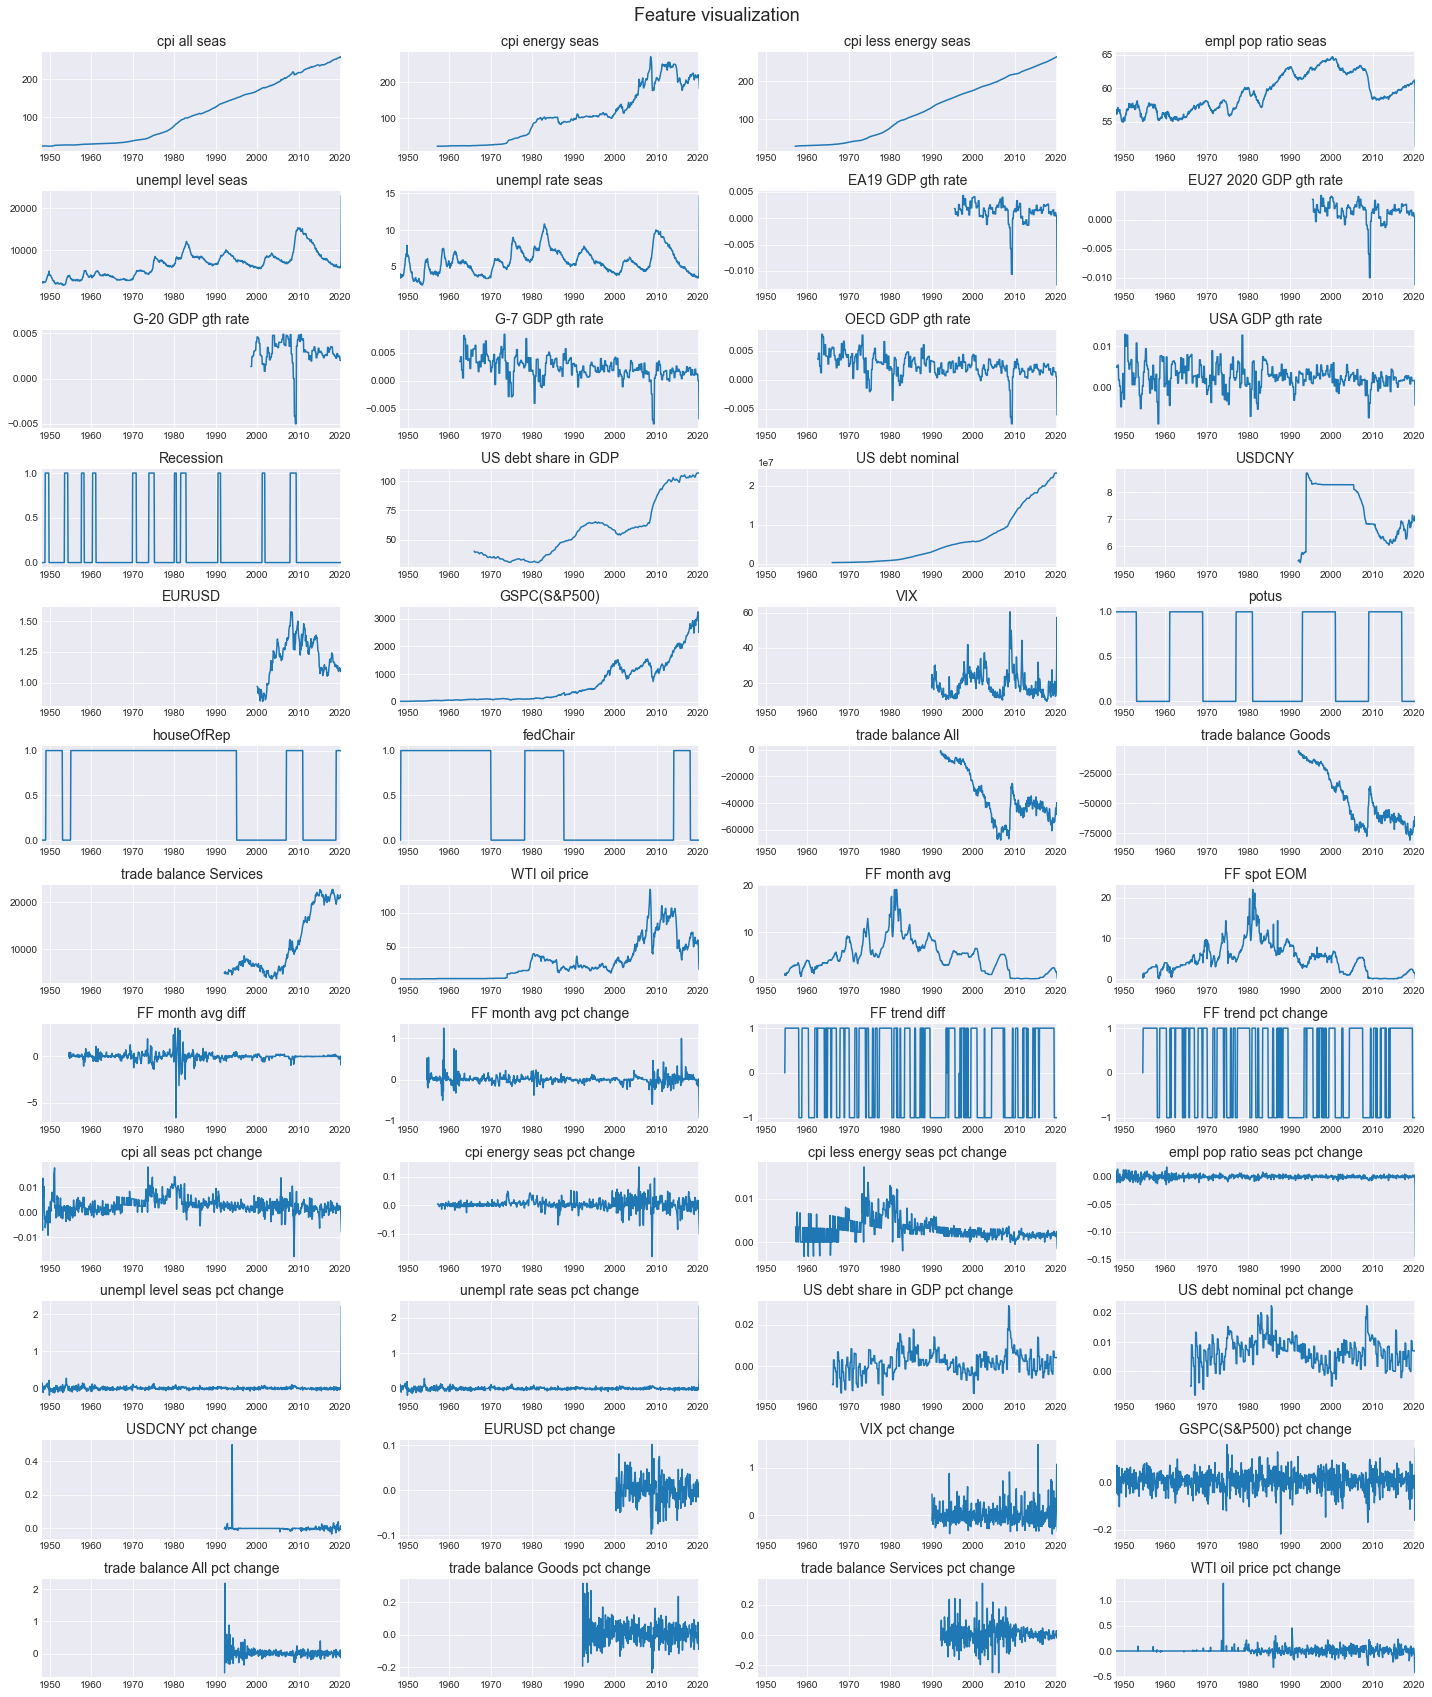

In [133]:
visualize_features(data=data,
                   excl_cols = settings.get('EXCL_COLS'),
                   date_col='Date',
                   ncols=4
                  )

## Feature selection

### 1. Feature stationarity

https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/a

#### Dickey-Fuller test to ensure stationarity of variables

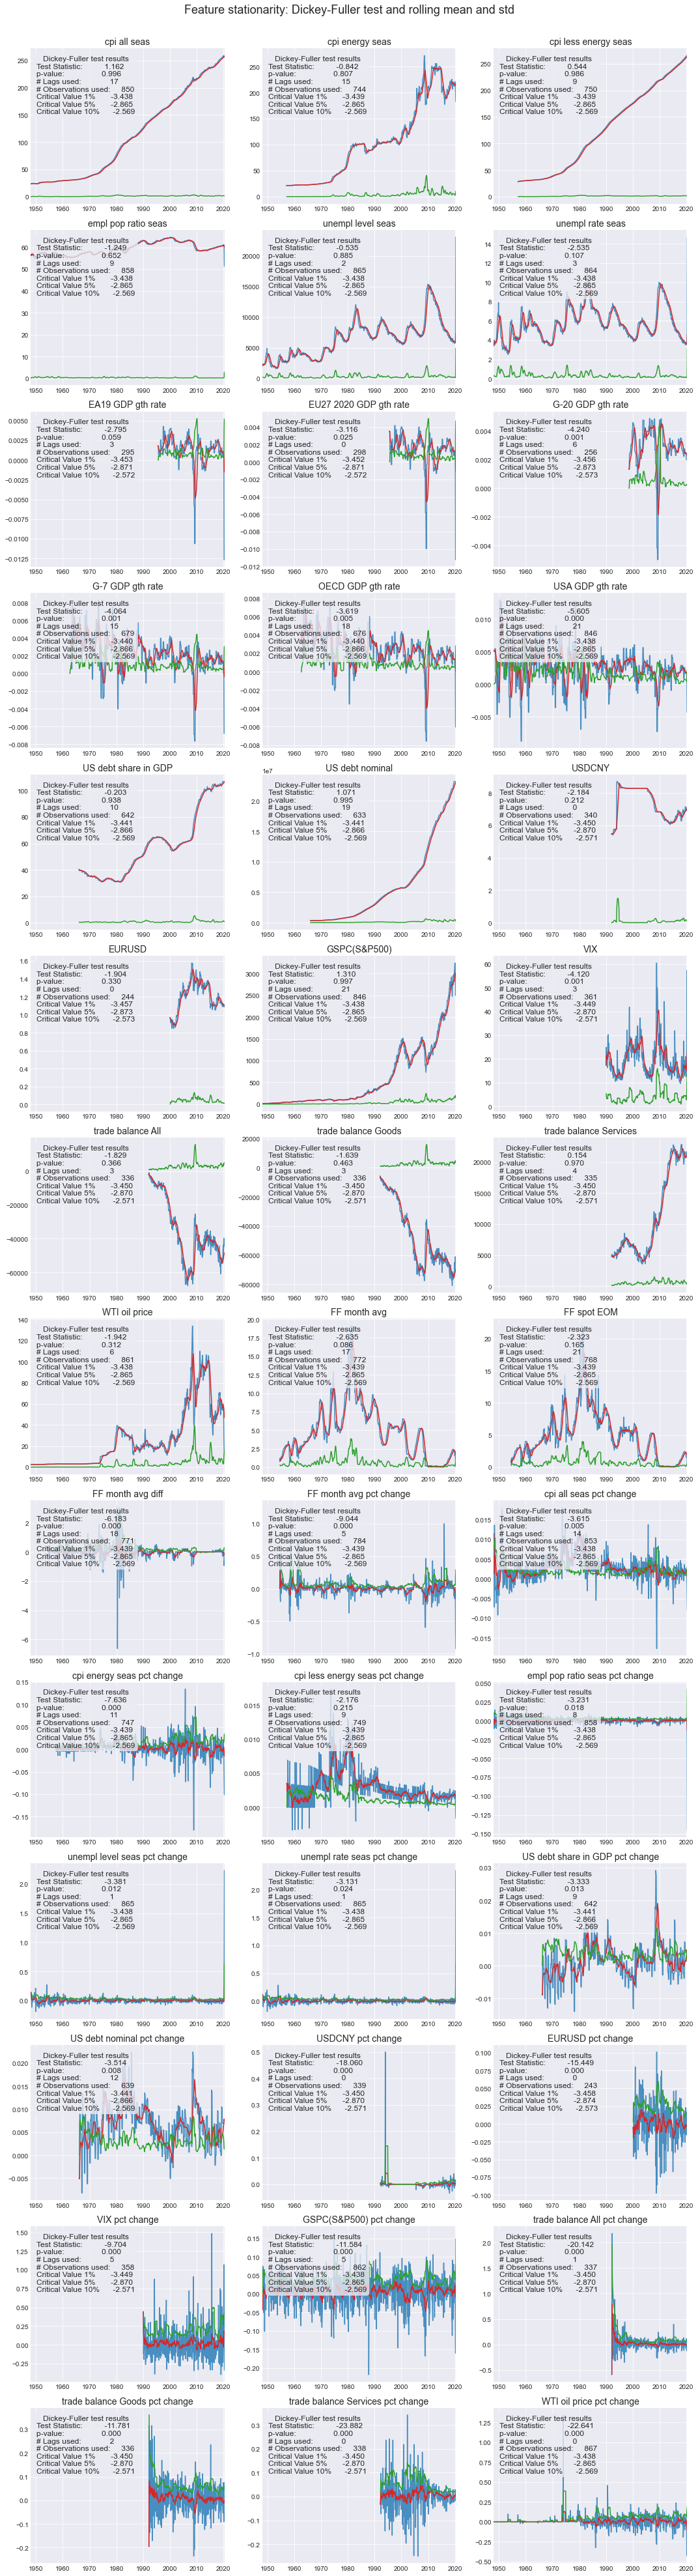

In [134]:
stat_results = test_stationarity(data,
                                columns=settings.get('NUM_COLS'),
                                excl_cols=settings.get('EXCL_COLS'),
                                date_col='Date',
                                stat_conf_level='5%',
                                plot_graphs=True,
                                plot_test_results=True
                               )

#### Take only stationary features, keep only one of original feature and "_pct_change"

In [135]:
kept_cols, dropped_cols = remove_non_stationary_features(X, stat_results)
settings.update('EXCL_COLS', settings.get('EXCL_COLS') + dropped_cols)
settings.update('KEPT_COLS',kept_cols)
X.describe()


------------------------------------- Non-stationarity: following features dropped -------------------------------------
cpi_all_seas
cpi_energy_seas
cpi_less_energy_seas
empl_pop_ratio_seas
unempl_level_seas
unempl_rate_seas
EA19_GDP_gth_rate
US_debt_share_in_GDP
US_debt_nominal
USDCNY
EURUSD
GSPC(S&P500)
VIX_pct_change
trade_balance_All
trade_balance_Goods
trade_balance_Services
WTI_oil_price
FF_month_avg
FF_spot_EOM


cpi_all_seas_pct_change  cpi_energy_seas_pct_change  \
count               868.000000                  759.000000   
mean                  0.002765                    0.003052   
std                   0.003338                    0.020865   
min                  -0.017705                   -0.180245   
25%                   0.000992                   -0.004175   
50%                   0.002417                    0.003158   
75%                   0.004253                    0.009678   
max                   0.018100                    0.134605   

       cpi_less_energy_seas_pct_change  empl_pop_ratio_seas_pct_change  \
count                       759.000000                      867.000000   
mean                          0.002950                       -0.000093   
std                           0.002514                        0.006103   
min                          -0.003356                       -0.145000   
25%                           0.001494                       -0.001706   
50%                           0.002440                        0.000000   
75%                           0.003647                        0.001721   
max                           0.017429                        0.018051   

       unempl_level_seas_pct_change  unempl_rate_seas_pct_change  \
count                    867.000000                   867.000000   
mean                       0.004765                     0.003751   
std                        0.085177                     0.088649   
min                       -0.187144                    -0.189873   
25%                       -0.019261                    -0.021277   
50%                       -0.000404                     0.000000   
75%                        0.019357                     0.020204   
max                        2.232213                     2.340909   

       EU27_2020_GDP_gth_rate  G-20_GDP_gth_rate  G-7_GDP_gth_rate  \
count              299.000000         263.000000        695.000000   
mean                 0.001334           0.002928          0.002295   
std                  0.002113           0.001510          0.002114   
min                 -0.011226          -0.004994         -0.007653   
25%                  0.000867           0.002458          0.001287   
50%                  0.001687           0.002930          0.002083   
75%                  0.002340           0.003784          0.003506   
max                  0.004199           0.004875          0.008321   

       OECD_GDP_gth_rate  ...  USDCNY_pct_change  EURUSD_pct_change  \
count         695.000000  ...         340.000000         244.000000   
mean            0.002456  ...           0.001086           0.000958   
std             0.001954  ...           0.028054           0.028302   
min            -0.007575  ...          -0.033474          -0.097206   
25%             0.001477  ...          -0.002281          -0.014062   
50%             0.002392  ...          -0.000073           0.000262   
75%             0.003564  ...           0.000145           0.018226   
max             0.007837  ...           0.500000           0.101047   

       GSPC(S&P500)_pct_change         VIX  trade_balance_All_pct_change  \
count               868.000000  365.000000                    339.000000   
mean                  0.006931   19.586438                      0.020354   
std                   0.041919    7.974378                      0.174109   
min                  -0.217817    9.590000                     -0.589832   
25%                  -0.017200   13.750000                     -0.046366   
50%                   0.009546   17.420000                      0.012985   
75%                   0.034208   22.900000                      0.069123   
max                   0.163047   60.470001                      2.178099   

       trade_balance_Goods_pct_change  trade_balance_Services_pct_change  \
count                      339.000000                         339.000000   
mean                         0.009265                       

In [136]:
# X[['Date', 'EURUSD_pct_change']].dropna().describe(include='all')

### 2. Feature seasonality

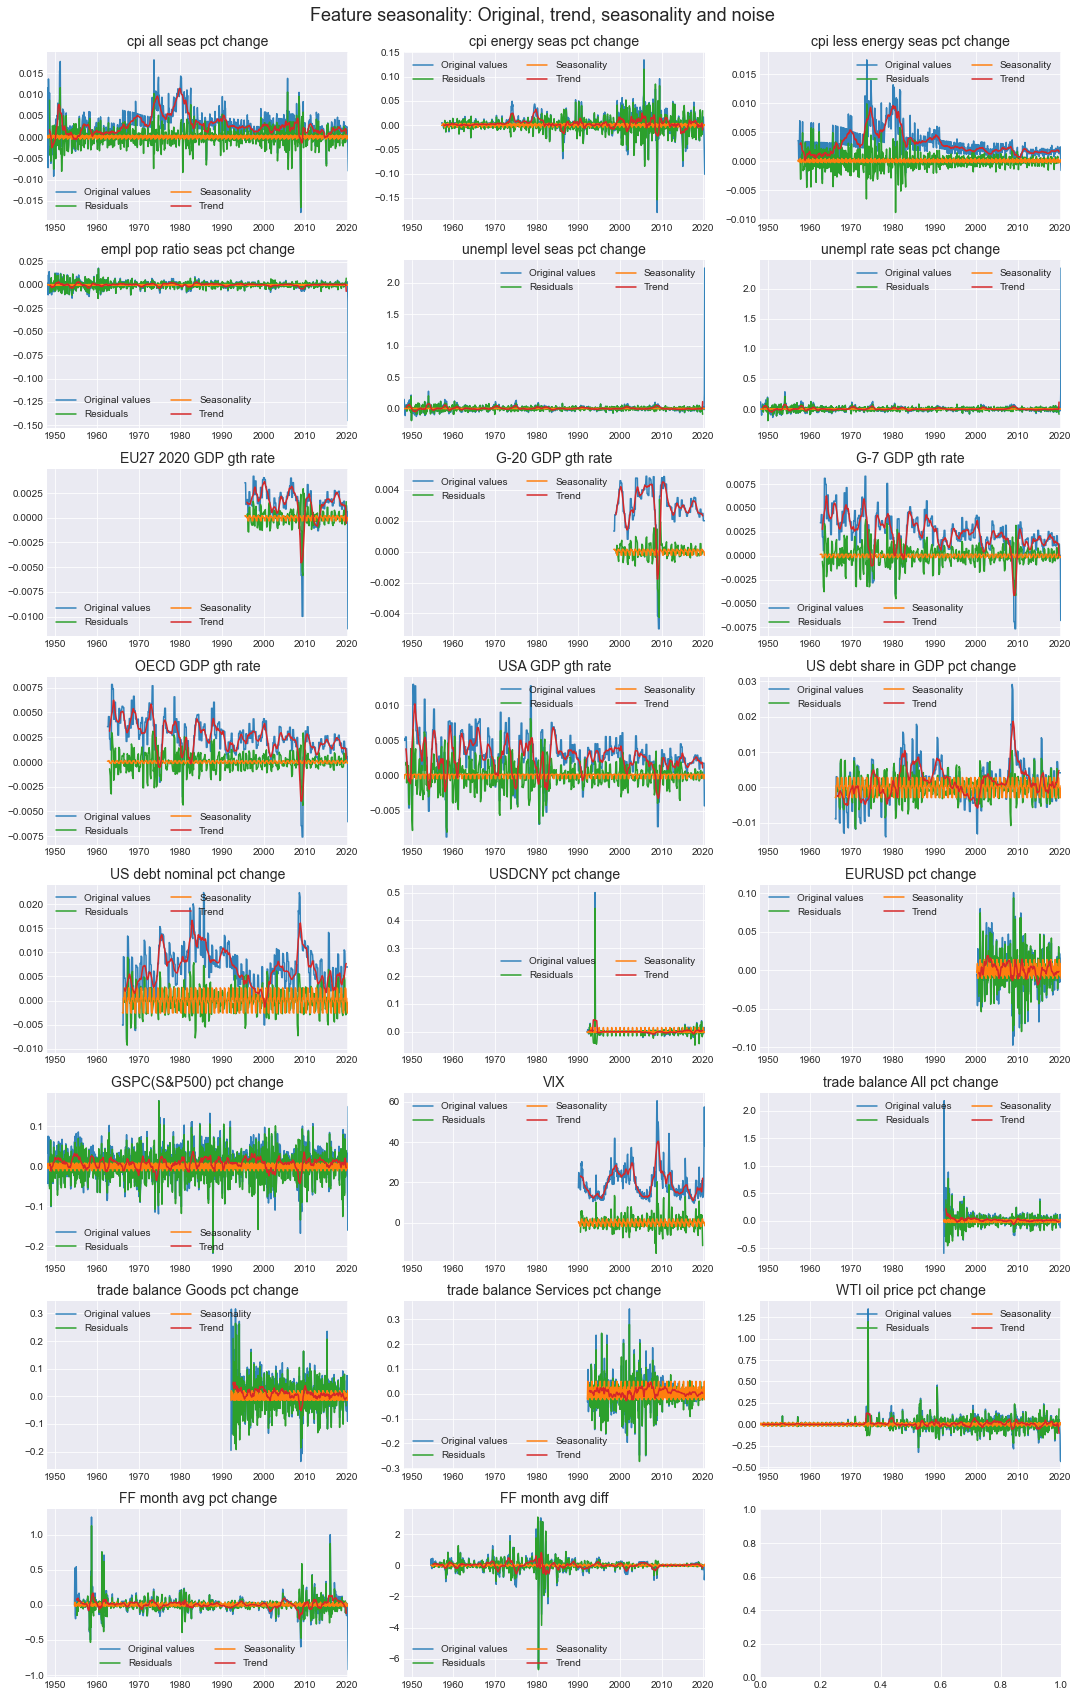

In [137]:
X_trend, X_seas, X_resid = seasonal_decomposition(X,
                                                 date_col='Date',
                                                 excl_cols=settings.get('NON_NUM_COLS'),
                                                 plot_graphs=True,
                                                 height_per_ax=3,
                                                 ncols=3
                                                )

In [138]:
_ = remove_seasonality(X, X_seas, threshold = 0.15)        

----------------------------------- Seasonality removed from the following features ------------------------------------
cpi_energy_seas_pct_change
cpi_less_energy_seas_pct_change
US_debt_share_in_GDP_pct_change
US_debt_nominal_pct_change
USDCNY_pct_change
EURUSD_pct_change
GSPC(S&P500)_pct_change
VIX
trade_balance_Goods_pct_change
trade_balance_Services_pct_change
WTI_oil_price_pct_change
FF_month_avg_pct_change
------------------------------ Following features not found in provided data or data_seas ------------------------------
Recession
potus
houseOfRep
fedChair


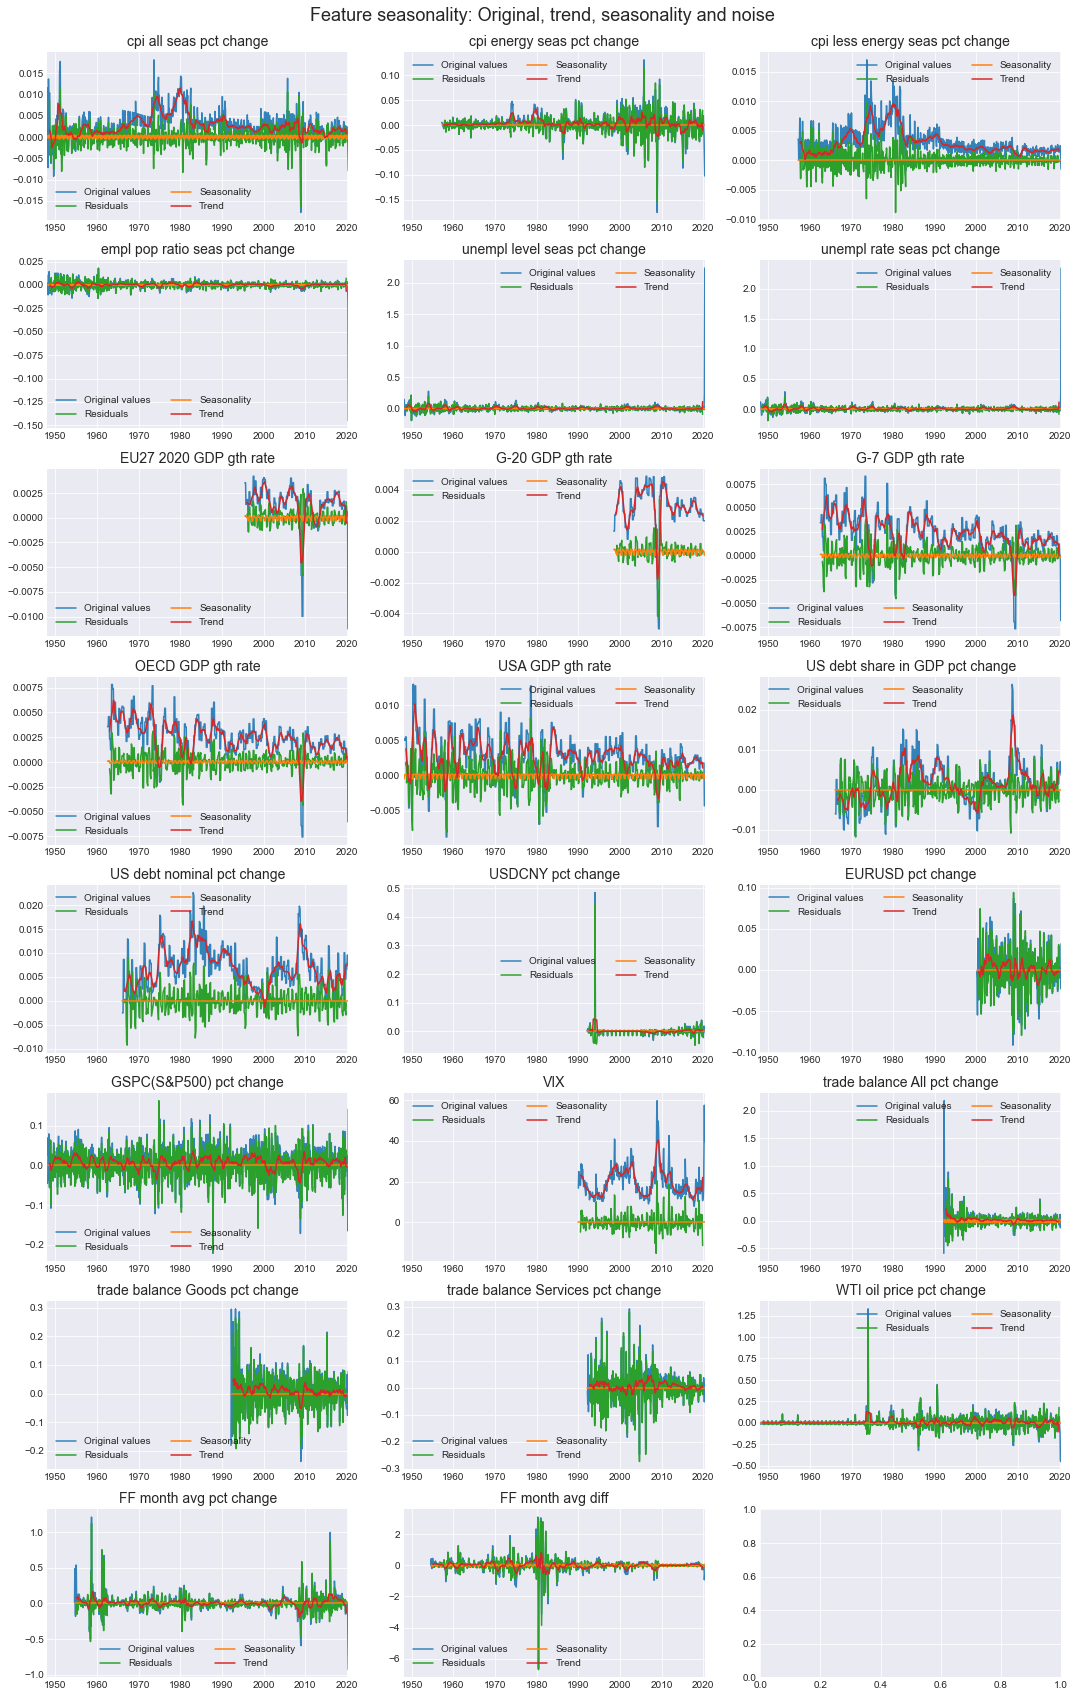

In [139]:
_, _, _ = seasonal_decomposition(X,
                                 date_col='Date',
                                 excl_cols=settings.get('NON_NUM_COLS'),
                                 plot_graphs=True,
                                 height_per_ax=3,
                                 ncols=3
                                )

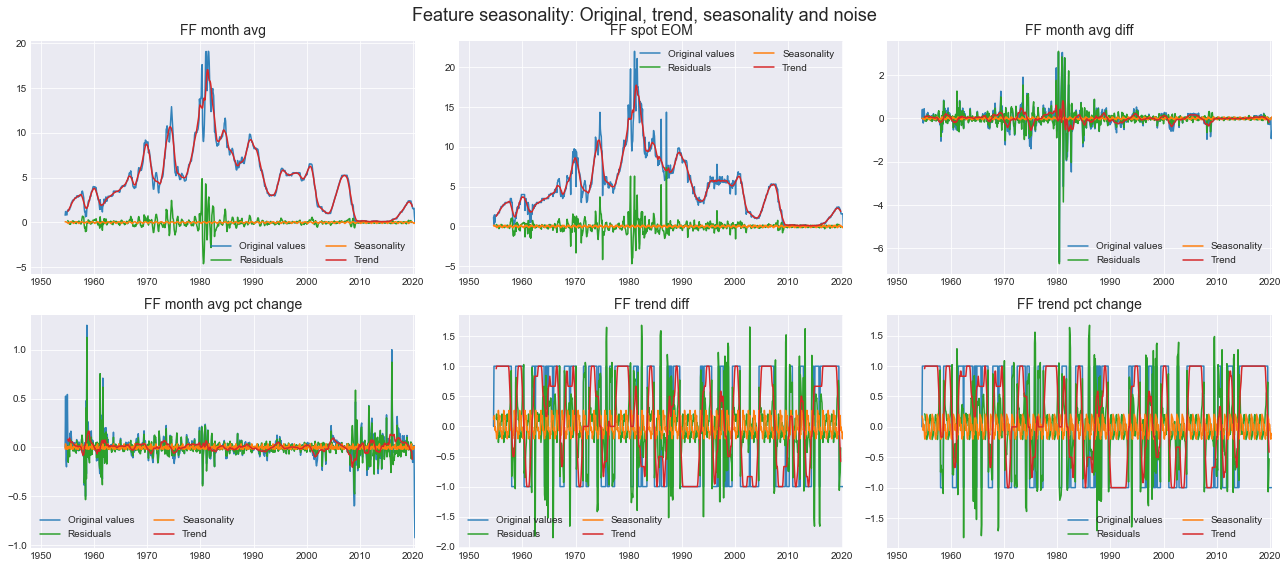

In [140]:
Y_trend, Y_seas, Y_resid = seasonal_decomposition(Y,
                                                 date_col='Date',
                                                 plot_graphs=True,
                                                 height_per_ax=4,
                                                 width_per_ax=6,                                                
                                                 ncols=3
                                                )

### 3. Feature normalization

In [141]:
scaled_cols = [x for x in settings.get('KEPT_COLS') if x in settings.get('NUM_COLS')]
X_scaled = preprocessing.StandardScaler().fit_transform(X[scaled_cols])
X[scaled_cols] = pd.DataFrame(X_scaled, columns=scaled_cols)

### 4. Add lagged features

In [142]:
# def shift_features(data, shifts = (1), columns=None, date_col='Date', excl_cols=[]):
#     if columns == None:
#         columns = data.columns
#     data_shifted = pd.DataFrame(index = data.index)
#     for col_name in columns:
#         if col_name == date_col or col_name in excl_cols:
#             continue
#         for t in shifts:
#             data_shifted[col_name + '_t-{:d}'.format(t)] = data[col_name].shift(t)
#     return data_shifted
        
data_shifted = shift_features(X,
                            row_shifts=(1, 2, 3, 6, 12)
                             )
X = pd.concat([X, data_shifted], axis=1)  

In [144]:
X.drop(columns=list(set(x.split("_t-")[0] for x in X.columns) - set(['Date'])), inplace=True)
X.columns

Index(['Date', 'cpi_all_seas_pct_change_t-1', 'cpi_all_seas_pct_change_t-2',
       'cpi_all_seas_pct_change_t-3', 'cpi_all_seas_pct_change_t-6',
       'cpi_all_seas_pct_change_t-12', 'cpi_energy_seas_pct_change_t-1',
       'cpi_energy_seas_pct_change_t-2', 'cpi_energy_seas_pct_change_t-3',
       'cpi_energy_seas_pct_change_t-6',
       ...
       'FF_month_avg_pct_change_t-1', 'FF_month_avg_pct_change_t-2',
       'FF_month_avg_pct_change_t-3', 'FF_month_avg_pct_change_t-6',
       'FF_month_avg_pct_change_t-12', 'FF_month_avg_diff_t-1',
       'FF_month_avg_diff_t-2', 'FF_month_avg_diff_t-3',
       'FF_month_avg_diff_t-6', 'FF_month_avg_diff_t-12'],
      dtype='object', length=136)

### 3. Feature correlation

In [145]:
# set important dates for X and Y
settings.add('START_DATE', dt.datetime(2000, 1, 1))
settings.add('END_DATE', dt.datetime(2019, 12, 1))

#### Dropping features with NAN within start date and end date

In [146]:
# Only after START DATE
try:
    X = X.loc[(X['Date'] >= settings.get('START_DATE')) & (X['Date'] <= settings.get('END_DATE'))]
    Y = Y.iloc[X.index]
except IndexError:
    pass

# Removing features with NaN after STARTDATE
X = X.dropna(axis=1)

# Ensuring Y has values everywhere
# Y = Y.dropna()
# X = X.iloc[Y.index]

#### First correlation matrix

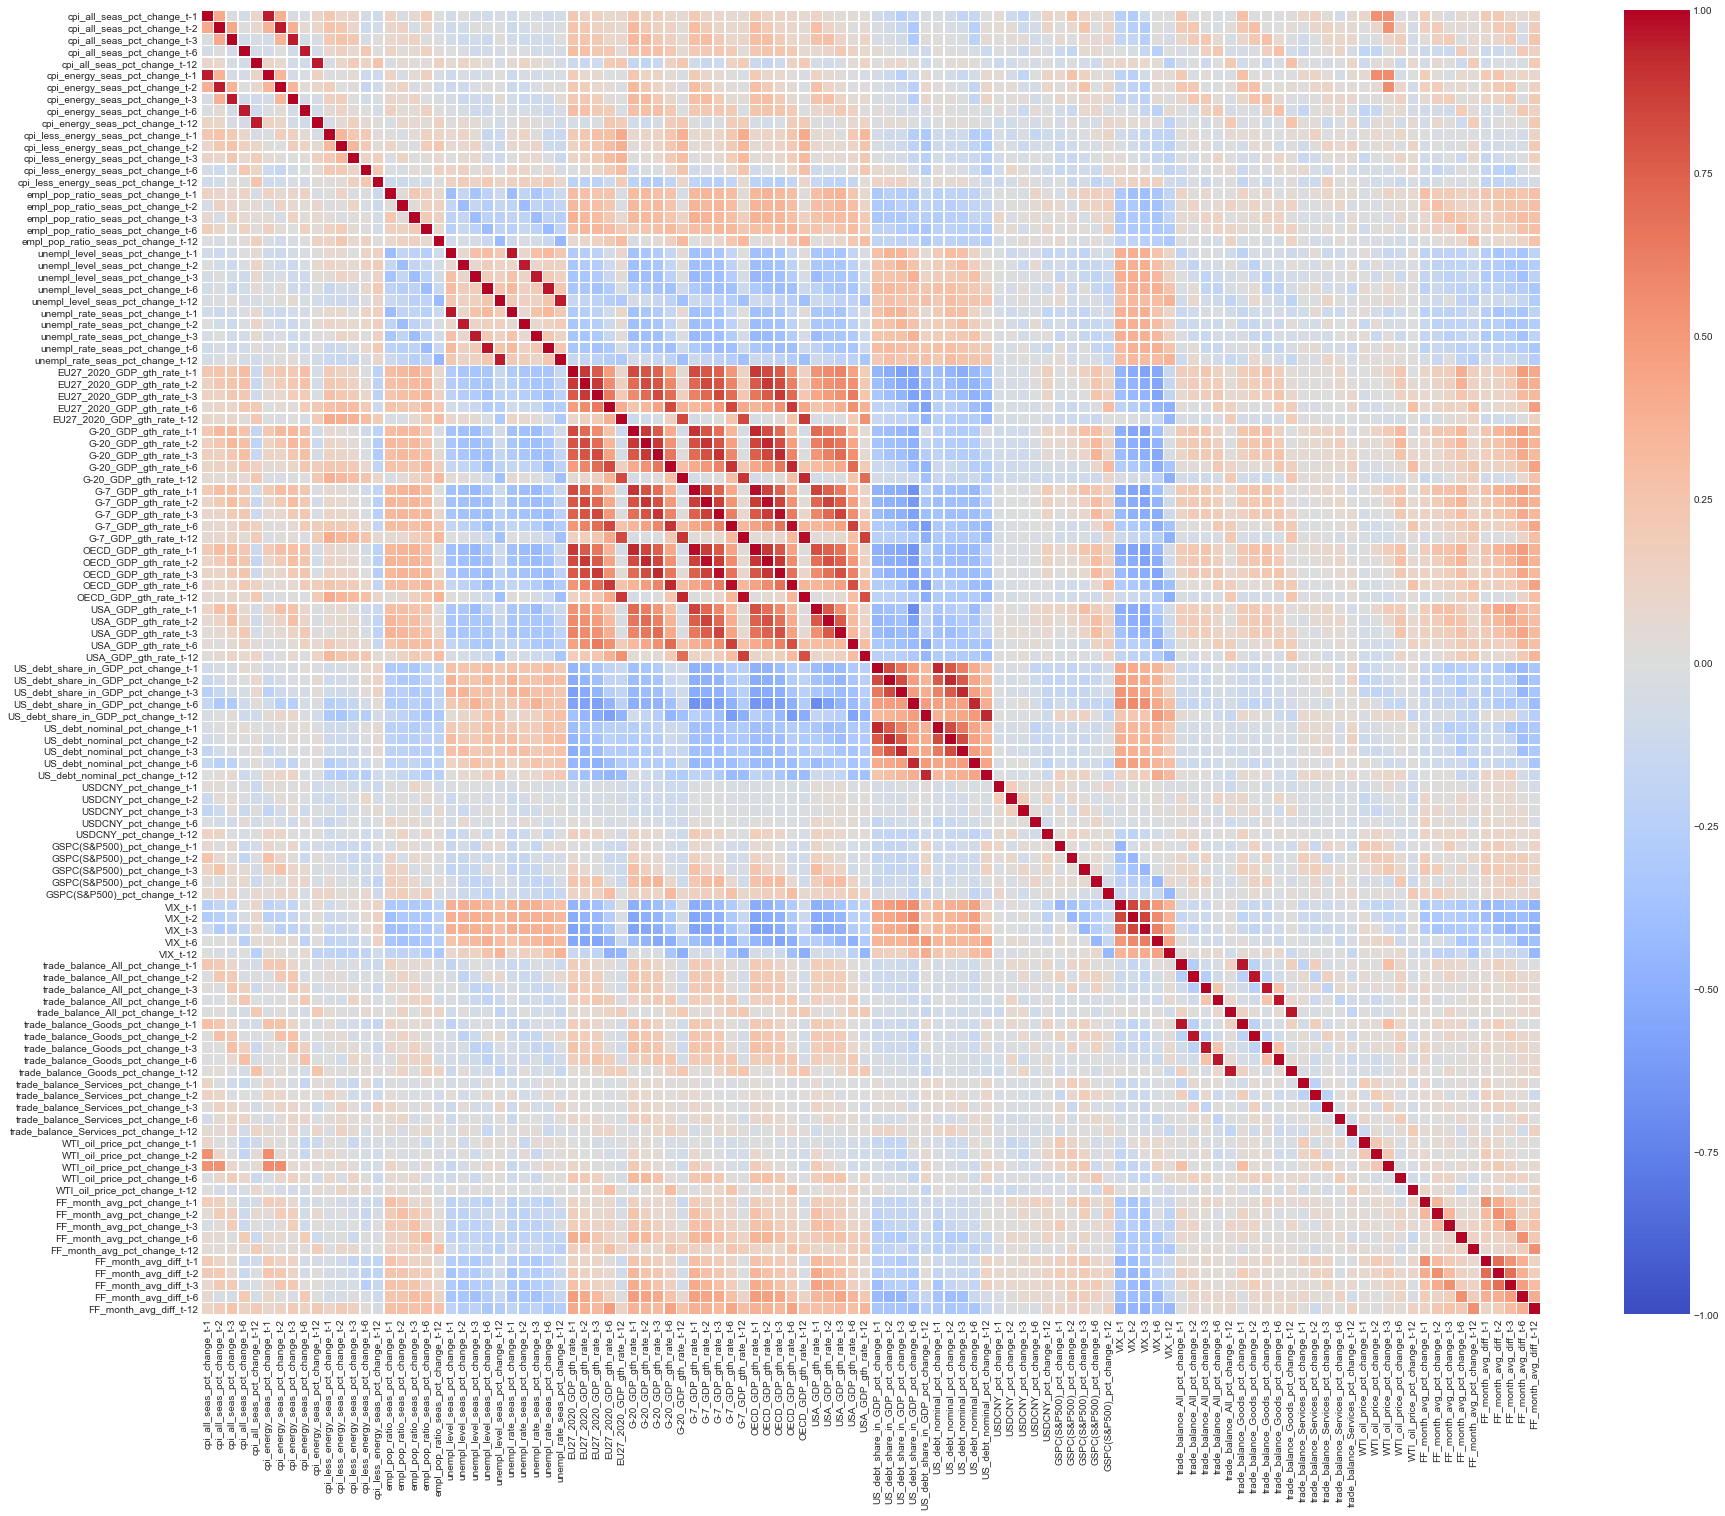

In [147]:
fig = plt.figure(figsize = (30, 24))
heat_map = sns.heatmap(X.dropna().corr(), cmap='coolwarm', linewidth=.5, vmin=-1, vmax=1)

#### VIF analysis

In [148]:
# Compute features to be analysed by VIF
columns_vif = [x for x in X.columns if x.split("_t-")[0] in settings.get('NUM_COLS')]

In [149]:
vif, excl_columns_vif = vif_analysis(X, columns_vif)
vif.sort_values('VIF_factor')


----------------------------------------- VIF analysis starting: 110 features ------------------------------------------
------------------------------------------ VIF analysis succesfully completed ------------------------------------------
remaining features: 72
excluded features: 38


VIF_factor                               features
33    1.344401                  USDCNY_pct_change_t-1
55    1.403679  trade_balance_Services_pct_change_t-6
36    1.407113                  USDCNY_pct_change_t-6
37    1.437557                 USDCNY_pct_change_t-12
51    1.493567    trade_balance_Goods_pct_change_t-12
..         ...                                    ...
29    7.527260         US_debt_nominal_pct_change_t-2
44    8.141127                                VIX_t-3
20    8.933748             EU27_2020_GDP_gth_rate_t-1
43    9.074536                                VIX_t-1
21    9.105906             EU27_2020_GDP_gth_rate_t-3

[72 rows x 2 columns]

In [150]:
pd.DataFrame.from_dict(excl_columns_vif, orient='index', columns=['VIF value when excluded'])

VIF value when excluded
OECD_GDP_gth_rate_t-2                              594.010937
G-20_GDP_gth_rate_t-3                              376.509747
G-20_GDP_gth_rate_t-1                              269.913987
OECD_GDP_gth_rate_t-6                              248.971069
OECD_GDP_gth_rate_t-12                             211.032454
OECD_GDP_gth_rate_t-3                              185.313504
OECD_GDP_gth_rate_t-1                              174.313229
US_debt_share_in_GDP_pct_change_t-6                163.535440
G-7_GDP_gth_rate_t-2                               141.645049
G-20_GDP_gth_rate_t-12                             127.791826
G-20_GDP_gth_rate_t-6                               92.620959
cpi_all_seas_pct_change_t-1                         89.715645
cpi_all_seas_pct_change_t-3                         82.029967
cpi_all_seas_pct_change_t-2                         68.445867
US_debt_share_in_GDP_pct_change_t-2                 68.263087
cpi_all_seas_pct_change_t-6                         63.266975
G-7_GDP_gth_rate_t-1                                59.354541
cpi_all_seas_pct_change_t-12                        57.408861
G-7_GDP_gth_rate_t-3                                48.800003
G-20_GDP_gth_rate_t-2                               47.108827
G-7_GDP_gth_rate_t-12                               45.422842
trade_balance_All_pct_change_t-12                   42.354778
G-7_GDP_gth_rate_t-6                                41.147548
trade_balance_All_pct_change_t-2                    40.316601
unempl_rate_seas_pct_change_t-2                     39.518473
trade_balance_All_pct_change_t-6                    35.317222
trade_balance_All_pct_change_t-1                    30.641045
trade_balance_All_pct_change_t-3                    27.957492
US_debt_share_in_GDP_pct_change_t-12                24.753649
US_debt_share_in_GDP_pct_change_t-3                 22.974880
unempl_level_seas_pct_change_t-6                    20.723995
unempl_rate_seas_pct_change_t-3                     20.427815
unempl_level_seas_pct_change_t-1                    20.032629
unempl_level_seas_pct_change_t-12                   18.908349
VIX_t-2                                             18.221278
EU27_2020_GDP_gth_rate_t-2                          16.911803
US_debt_nominal_pct_change_t-1                      15.956542
USA_GDP_gth_rate_t-2                                12.108640

In [151]:
for col_name in excl_columns_vif.keys():
    try:
        X.drop(columns=[col_name], inplace=True)
    except KeyError:
        print("Column {:s} have already been removed".format(col_name))

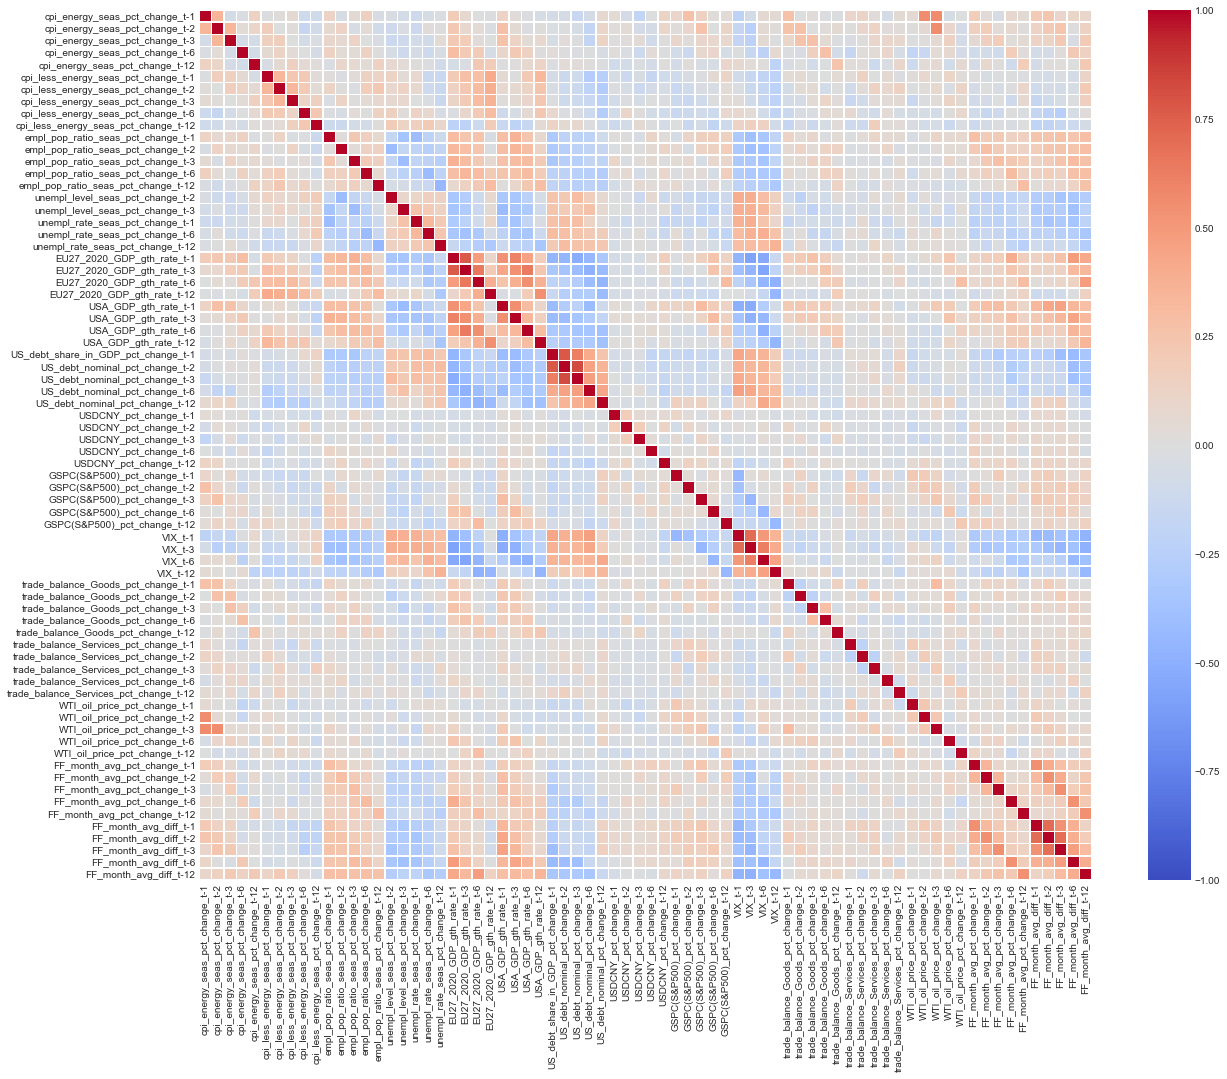

In [152]:
fig = plt.figure(figsize = (20, 16))
heat_map = sns.heatmap(X.dropna().corr(), cmap='coolwarm', linewidth=.5, vmin=-1, vmax=1)

## First models

In [ ]:
# visualize_features(data=X,
#                    date_col='Date',
#                    columns=
#                    ncols=4)

### 1. Train and Test split

In [153]:
settings.add('TEST_DATE', dt.datetime(2014, 1, 1))

X_train, X_test = X.loc[X['Date'] < settings.get('TEST_DATE')], X.loc[X['Date'] >= settings.get('TEST_DATE')]
Y_train, Y_test = Y.loc[Y['Date'] < settings.get('TEST_DATE')], Y.loc[Y['Date'] >= settings.get('TEST_DATE')]
X_train.drop(columns=['Date'], inplace=True)
X_test.drop(columns=['Date'], inplace=True)

### 2. Predicted feature, model type and related parameters

In [154]:
predicted_feature = 'FF_month_avg_diff'
# estimator = GradientBoostingRegressor(random_state=SEED)
estimator = RandomForestRegressor(random_state=SEED)

In [155]:
# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = np.arange(1, int(np.sqrt(len(X.columns))), 1)
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 6]
# Complexity parameter
ccp_alpha = [1e-6, 1e-5, 1e-4, 1e-2]
# Minimum number of samples required at each leaf node
max_depth = [1, 2, 3, 4, 5, 6]
# learning rate (shrinkage)
learning_rate = np.logspace(-3, -1, 3)

params_cv = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
#                'ccp_alpha': ccp_alpha,
#                'max_depth': max_depth,
#                'learning_rate':learning_rate
              }
params_cv

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': array([1, 2, 3, 4, 5, 6, 7, 8]),
 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}

### 3. Cross-validation

In [ ]:
results_cv = time_series_split_cv(X_train,
                                  Y_train[predicted_feature],
                                  estimator = estimator,
                                  params_cv = params_cv
                                 )


------------------------------------------ 5-folds Cross-validation starting -------------------------------------------
 Fitting 5 folds for each of 480 candidates, totalling 2400 fits 

-------------------------------------------------- Folder #1 starting --------------------------------------------------


### 4. Model performance

In [73]:
# Convert 'params' to str to perform pivot (otherwise error)
results_cv['params'] = results_cv['params'].apply(lambda x: str(x))

# Pivot table to get the mean values for each params over all folds
mean_results_cv = pd.pivot_table(results_cv,
                                 values=['training score', 'validation score'],
                                 index='params',
                                 aggfunc=np.mean
                                )
mean_results_cv.reset_index(level='params', inplace=True)

# Convert 'params' back to dict
mean_results_cv['params'] = mean_results_cv['params'].apply(lambda x: ast.literal_eval(x)) 
mean_results_cv.sort_values('validation score', ascending=False).head(20)

params  training score  \
426  {'n_estimators': 400, 'max_features': 9, 'min_...        0.962678   
318  {'n_estimators': 200, 'max_features': 9, 'min_...        0.963641   
480  {'n_estimators': 600, 'max_features': 9, 'min_...        0.962441   
48   {'n_estimators': 1000, 'max_features': 9, 'min...        0.961222   
102  {'n_estimators': 1200, 'max_features': 9, 'min...        0.960613   
534  {'n_estimators': 800, 'max_features': 9, 'min_...        0.961528   
319  {'n_estimators': 200, 'max_features': 9, 'min_...        0.938253   
320  {'n_estimators': 200, 'max_features': 9, 'min_...        0.899742   
210  {'n_estimators': 1600, 'max_features': 9, 'min...        0.960911   
156  {'n_estimators': 1400, 'max_features': 9, 'min...        0.960600   
428  {'n_estimators': 400, 'max_features': 9, 'min_...        0.894852   
372  {'n_estimators': 2000, 'max_features': 9, 'min...        0.961097   
264  {'n_estimators': 1800, 'max_features': 9, 'min...        0.960971   
427  {'n_estimators': 400, 'max_features': 9, 'min_...        0.933769   
481  {'n_estimators': 600, 'max_features': 9, 'min_...        0.933601   
211  {'n_estimators': 1600, 'max_features': 9, 'min...        0.932172   
49   {'n_estimators': 1000, 'max_features': 9, 'min...        0.932215   
373  {'n_estimators': 2000, 'max_features': 9, 'min...        0.932318   
103  {'n_estimators': 1200, 'max_features': 9, 'min...        0.931496   
470  {'n_estimators': 600, 'max_features': 7, 'min_...        0.876365   

     validation score  
426         -1.362123  
318         -1.438899  
480         -1.447513  
48          -1.494560  
102         -1.525744  
534         -1.529924  
319         -1.531728  
320         -1.556895  
210         -1.578375  
156         -1.617386  
428         -1.640786  
372         -1.642889  
264         -1.646079  
427         -1.668050  
481         -1.683084  
211         -1.700969  
49          -1.704027  
373         -1.708708  
103         -1.720623  
470         -1.725105

In [86]:
file_name = 'cv_{:s}_feature_{:s}_{:s}'.format(str(estimator.__class__.__name__),
                                                  predicted_feature.replace(" ", "_"),
                                                   dt.datetime.today().strftime("%Y%m%d")
                                         )
i = 0
while os.path.exists('Models/' + file_name + "_{:d}".format(i)):
    i += 1
file_name += '_{:d}'.format(i)
mean_results_cv.to_csv('Models/' + file_name + '.csv', sep=";")

In [75]:
# best_model = mean_results_cv.loc[260]
best_model = mean_results_cv.loc[mean_results_cv['validation score'].idxmax]
with pd.option_context('max_colwidth', None):
    print(best_model)

params              {'n_estimators': 400, 'max_features': 9, 'min_samples_leaf': 1}
training score                                                             0.962678
validation score                                                           -1.36212
Name: 426, dtype: object


Training score: 0.9643860367856159
Test score: 0.7503748242925806


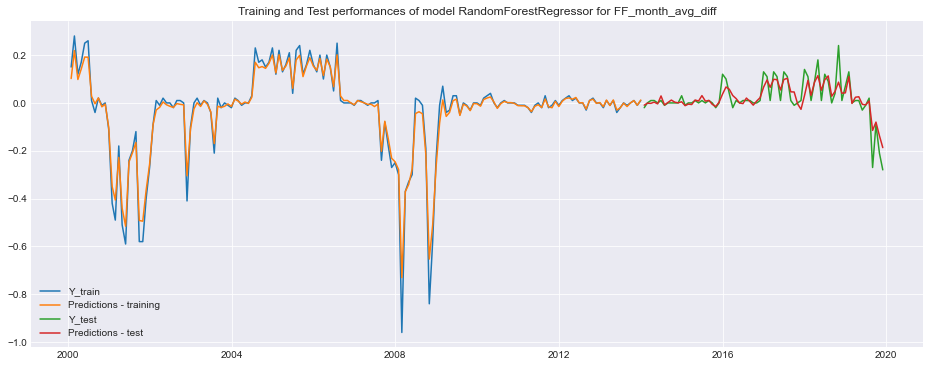

(0.9643860367856159, 0.7503748242925806)

In [77]:
# model = MLPRegressor(hidden_layer_sizes = (200, 200, 200, 200, 100),
#                      activation='tanh',
#                      alpha=10
#                     )
# model = GradientBoostingRegressor()
# model = LinearRegression()
model = estimator.set_params(**best_model.loc['params'])
model.fit(X_train, Y_train[predicted_feature])
tr_score, test_score = plot_model_and_metrics(X_train, X_test, Y_train, Y_test, predicted_feature, model)

In [80]:
import joblib
import os
file_name = '{:s}_feature_{:s}_test_score_{:.3f}'.format(str(estimator.__class__.__name__),
                                                         predicted_feature.replace(" ", "_"),
                                                         test_score
                                                        ).replace(".", "")
i = 1
while os.path.exists('Models/' + file_name + '_{:d}'.format(i)):
    i += 1
file_name += '_{:d}'.format(i)

joblib.dump(model, 'Models/' + file_name + '.pkl', compress = 1) # Only best parameters

RandomForestRegressor_feature_FF_month_avg_diff_test_score_0750


['Models/RandomForestRegressor_feature_FF_month_avg_diff_test_score_0750_1.pkl']